# Classification Demo

## Cross-Entropy Illustration

We start by demonstrating the cross-entropy value of different predictions compared to a true label. In this case, we have three classes, and a datapoint has been labeled as being in the first class. This means the best-possible probability output is `[1,0,0]`, expressing a 100% probability of being in class 1, and a 0% probability of being in classes 2 or 3.

Cross-entropy error, like the error function from logistic regression, is derived from maximum likelihood. Assume the output probabilities on the datapoints are correct. The probability that the data would get the label they did is the likelihood. The output probabilities that maximize this likelihood is the maximum likelihood solution. Cross entropy is just taking the maximum likelihood optimization, and doing algebra to it to rework it and make it more numerically stable to compute.

The below code demonstrates how the cross-entropy error changes for a single datapoint as the prediction gets more accurate. The target is `[1,0,0]`. The x-axis on the plot is the predicted probability, and the y-axis is the cross-entropy error. You can see that as the prediction gets more accurate, the loss drops. However, it drops most rapidly when it is very wrong. When it's already close to right, there is relatively little reward for getting even more correct. As a result, cross-entropy error results in solutions where the predictions are pretty right, but it won't make one datapoint a little more accurate if it would mean making another a little more wrong.

In [1]:
import numpy as np

In [2]:
def cross_entropy(output, target):
    epsilon = 1e-12
    #log(0) is an error, so we make zeros very small non-zero numbers to avoid that
    output = np.clip(output, epsilon, 1-epsilon)
    return -np.sum(target*np.log(output))

In [3]:
xs = np.linspace(0,1,num=100)
ces = [cross_entropy([x, (1-x)/2, (1-x)/2],[1,0,0]) for x in xs]

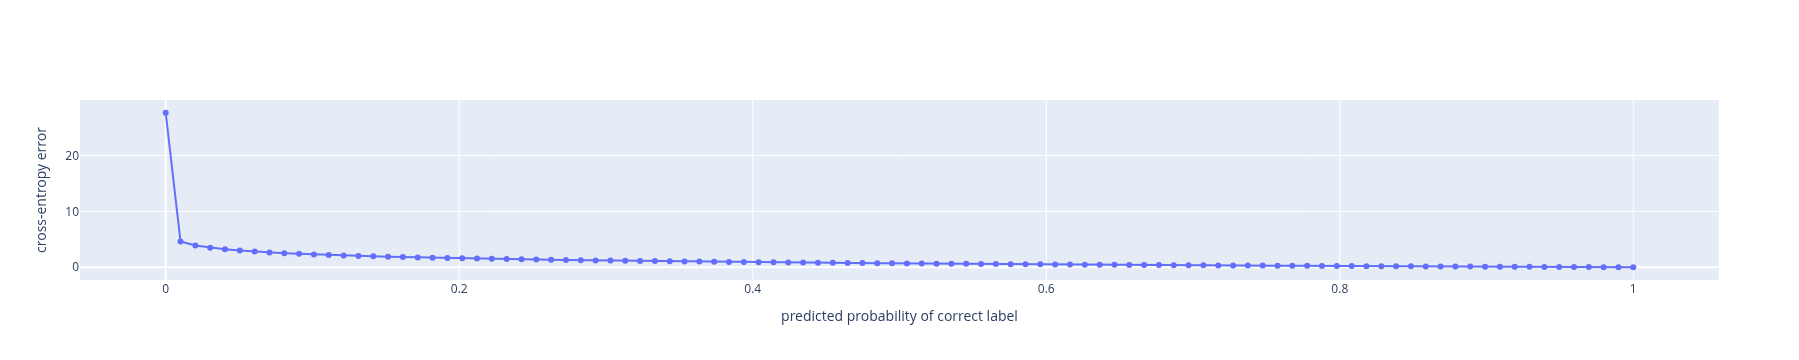

In [4]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=xs,
    y=ces,
    mode='lines+markers'
))
fig.update_layout(
    xaxis_title='predicted probability of correct label',
    yaxis_title='cross-entropy error'
)
fig.show()

## pytorch Classification Example

We create a synthetic dataset of 10,000 datapoints, split into 3 classes. We use `sklearn.datasets.make_classification` so that the features are actually predictive of the labels, so there's something to learn.

Given our `(X,y)` dataset, we do the following:
- Split it into train/test sets.
- Scale the training/testing data. We scale the training data, then apply the learned scaler to the testing data, as well. It's not strictly necessary to scale features here; in theory, the network can learn to adjust to different feature scales. In practice, learning goes faster if features are scaled.
- We convert the data to tensors. Most network parameters are 32-bit numbers or even 16-bit numbers, because they're faster to do math with, and the extra precision isn't empirically necessary. We make our dataset 32-bit floats so that they are the same precision as the parameters. If we used anything else, we'd get an error. Pytorch also expects that labels are longs, so we do that when we make the y values tensors.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [6]:
# 1. --- Data Preparation ---

# Create a synthetic dataset
# n_features=10: 10 input features
# n_classes=3: multi-class classification
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=2, n_classes=3)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale features to make learning easier
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert NumPy arrays to PyTorch Tensors
# We need FloatTensors for features
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# For CrossEntropyLoss, we need class indices as LongTensors
# The shape should be (n_samples), not (n_samples, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(f"Training data shape: {X_train_tensor.shape}")
print(f"Test data shape: {X_test_tensor.shape}")

Training data shape: torch.Size([8000, 10])
Test data shape: torch.Size([2000, 10])


We create a model. This model has two hidden layers, one of 64 nodes, and one of 32 nodes. The output layer is not put through an activation function, and is outputting logits.

In [7]:
# 2. --- Define the Model ---

class SimpleClassifier(nn.Module):
    def __init__(self, input_features, num_classes):
        super(SimpleClassifier, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(input_features, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, num_classes) # Output for each class

    def forward(self, x):
        # Define the forward pass
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x) # Raw output (logits)
        return x

# Get the number of input features from the data
input_features = X_train.shape[1]
num_classes = 3
model = SimpleClassifier(input_features, num_classes)
print("\nModel Architecture:")
print(model)


Model Architecture:
SimpleClassifier(
  (layer1): Linear(in_features=10, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=3, bias=True)
)


We use `CrossEntropyLoss` as our loss function. `CrossEntropyLoss` expects logits and integer labels, converts both of them to probability vectors, and then calculates the cross-entropy. There are a couple new things here.

First, we're using `Adam` as our optimizer, not `SGD`. `Adam` is very similar to `SGD`, but also includes "momentum," which usually leads to faster and more stable optimization.

Second, note the `model.train()` and `model.eval()` in the code. There are special types of layers like Dropout or BatchNorm that behave differently when training versus when just doing forward passes (in particular, there is randomness in training, which is good for training but results in inconsistent predictions in evaluation). `model.train()` sets the model in the "now we're going to do backward passes" mode, while `model.eval()` sets it in "we're only producing predictions, we're not doing training" mode. Relatedly, `torch.no_grad()` tells torch not to bother computing any gradients, we're only doing forward passes. `torch.no_grad()` greatly increases speed and decreases memory usage since it's not doing all the gradient work.

Note that to find the predicted labels of the test set, we just take the argmax of the logits - the largest logit will produce the largest probability, is the most likely label.

In [8]:
# 3. --- Loss Function and Optimizer ---

# CrossEntropyLoss is used for multi-class classification.
# It internally applies a Softmax function to the model's raw logits
# and then calculates the NLLLoss (Negative Log Likelihood Loss).
criterion = nn.CrossEntropyLoss()

# Use the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. --- Training Loop ---

num_epochs = 1000
print_every = 100

print("\n--- Starting Training ---")
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    # --- Forward pass ---
    # Get model predictions (logits)
    y_pred_logits = model(X_train_tensor)
    
    # --- Calculate loss ---
    loss = criterion(y_pred_logits, y_train_tensor)
    
    # --- Backward pass and optimization ---
    # 1. Zero out the gradients from the previous pass
    optimizer.zero_grad()
    
    # 2. Perform backpropagation
    loss.backward()
    
    # 3. Update the model's weights
    optimizer.step()
    
    # --- Print progress ---
    if (epoch + 1) % print_every == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("--- Training Finished ---")

# 5. --- Evaluation ---

# Set model to evaluation mode (disables dropout, batch norm, etc.)
model.eval()

# We don't need to track gradients during evaluation
with torch.no_grad():
    # Get predictions on the test set (raw logits)
    # Shape will be [n_samples, 3]
    y_test_logits = model(X_test_tensor)
    
    # Convert logits to predicted class index
    # torch.argmax finds the index of the highest score along dimension 1
    # This corresponds to the most likely class
    y_test_preds = torch.argmax(y_test_logits, dim=1)
    
    # Calculate accuracy
    # .numpy() converts the tensor back to a NumPy array for use with sklearn
    accuracy = accuracy_score(y_test_tensor.numpy(), y_test_preds.numpy())
    
    print(f"\n--- Evaluation on Test Set ---")
    print(f"Accuracy: {accuracy * 100:.2f}%")




--- Starting Training ---
Epoch [100/1000], Loss: 0.5485


/home/scs/taylor/mambaforge/envs/book/lib/python3.13/site-packages/torch/autograd/graph.py:841: UserWarning:

CUDA initialization: The NVIDIA driver on your system is too old (found version 12090). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)



Epoch [200/1000], Loss: 0.4051
Epoch [300/1000], Loss: 0.3207
Epoch [400/1000], Loss: 0.2683
Epoch [500/1000], Loss: 0.2373
Epoch [600/1000], Loss: 0.2158
Epoch [700/1000], Loss: 0.1994
Epoch [800/1000], Loss: 0.1866
Epoch [900/1000], Loss: 0.1756
Epoch [1000/1000], Loss: 0.1658
--- Training Finished ---

--- Evaluation on Test Set ---
Accuracy: 90.65%


## Large-Scale Training

In a large-scale process, we have to add batching, where we cannot train on the whole training set at once, because it's just too large. This capability is baked into pytorch using `Dataset`s and `DataLoader`s.

The below repeats that whole thing we just did, but demonstrating those tools to train on only 64 datapoints at a time.

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# 1. --- Data Preparation ---

# Create a synthetic dataset
# n_features=10: 10 input features
# n_classes=3: multi-class classification
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=2, n_classes=3, random_state=42)

# Split into training and test sets FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert NumPy arrays to PyTorch Tensors
# We need FloatTensors for features
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# For CrossEntropyLoss, we need class indices as LongTensors
# The shape should be (n_samples), not (n_samples, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# --- Create Datasets and DataLoaders ---
# Wrap tensors in TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define batch size
batch_size = 64

# Create DataLoaders
# shuffle=True is important for the training loader to ensure batches are different each epoch
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# shuffle=False is standard for the test/validation loader
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


print(f"Training data shape: {X_train_tensor.shape}")
print(f"Test data shape: {X_test_tensor.shape}")
print(f"Using batch size: {batch_size}")

# 2. --- Define the Model ---

class SimpleClassifier(nn.Module):
    def __init__(self, input_features, num_classes):
        super(SimpleClassifier, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(input_features, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, num_classes) # Output for each class

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output_layer(x) # Raw output (logits)
        return x

# Get the number of input features from the data
input_features = X_train.shape[1]
num_classes = 3
model = SimpleClassifier(input_features, num_classes)
print("\nModel Architecture:")
print(model)

# 3. --- Loss Function and Optimizer ---

# CrossEntropyLoss is used for multi-class classification.
# It internally applies a Softmax function to the model's raw logits
# and then calculates the NLLLoss (Negative Log Likelihood Loss).
criterion = nn.CrossEntropyLoss()

# Use the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. --- Training Loop ---

num_epochs = 100
print_every = 10

print("\n--- Starting Training ---")
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    total_loss = 0.0
    
    # --- Loop over batches ---
    for inputs, labels in train_loader:
        
        # --- Forward pass ---
        # Get model predictions (logits)
        y_pred_logits = model(inputs)
        
        # --- Calculate loss ---
        loss = criterion(y_pred_logits, labels)
        
        # --- Backward pass and optimization ---
        # 1. Zero out the gradients from the previous pass
        optimizer.zero_grad()
        
        # 2. Perform backpropagation
        loss.backward()
        
        # 3. Update the model's weights
        optimizer.step()
        
        total_loss += loss.item()
    
    # --- Print progress ---
    # Calculate average loss over all batches
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % print_every == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("--- Training Finished ---")

# 5. --- Evaluation ---

# Set model to evaluation mode (disables dropout, batch norm, etc.)
model.eval()

# We don't need to track gradients during evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    # --- Loop over batches in the test loader ---
    for inputs, labels in test_loader:
        # Get predictions on the test set (raw logits)
        # Shape will be [batch_size, 3]
        y_test_logits = model(inputs)
        
        # Convert logits to predicted class index
        # torch.argmax finds the index of the highest score along dimension 1
        y_test_preds = torch.argmax(y_test_logits, dim=1)
        
        # Store batch predictions and labels
        all_preds.append(y_test_preds)
        all_labels.append(labels)

# Concatenate predictions and labels from all batches
all_preds_tensor = torch.cat(all_preds)
all_labels_tensor = torch.cat(all_labels)
    
# Calculate accuracy
# .numpy() converts the tensor back to a NumPy array for use with sklearn
accuracy = accuracy_score(all_labels_tensor.numpy(), all_preds_tensor.numpy())
    
print(f"\n--- Evaluation on Test Set ---")
print(f"Accuracy: {accuracy * 100:.2f}%")

Training data shape: torch.Size([8000, 10])
Test data shape: torch.Size([2000, 10])
Using batch size: 64

Model Architecture:
SimpleClassifier(
  (layer1): Linear(in_features=10, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=3, bias=True)
)

--- Starting Training ---
Epoch [10/100], Loss: 0.3268
Epoch [20/100], Loss: 0.2402
Epoch [30/100], Loss: 0.2033
Epoch [40/100], Loss: 0.1836
Epoch [50/100], Loss: 0.1678
Epoch [60/100], Loss: 0.1566
Epoch [70/100], Loss: 0.1493
Epoch [80/100], Loss: 0.1383
Epoch [90/100], Loss: 0.1350
Epoch [100/100], Loss: 0.1306
--- Training Finished ---

--- Evaluation on Test Set ---
Accuracy: 94.40%


## Tensorboard

It's common to want to track your network's training process. Google built a great tool called Tensorboard, which was intended to be used with TensorFlow, their pytorch competitor. It's good enough that they made it open-source, and has been integrated into pytorch.

To install tensorboard, you'll need to run `pip install tensorboard`.

Tensorboard is complicated, and I don't intend to teach it all. But, it can be a fun tool to play with, and generates a lot of the graphs you'd want to generate, like loss over time, or testing performance over time. Notice on the plots below how testing error first quickly improves, and then gets worse - overfitting!

Note this example also demonstrates how to evaluate your model's performance on the testing set while training by adding that computation into the training loop.



In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter # Import TensorBoard

# 1. --- Data Preparation ---

# Create a synthetic dataset
# n_features=10: 10 input features
# n_classes=3: multi-class classification
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=2, n_classes=3, random_state=42)

# Split into training and test sets FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert NumPy arrays to PyTorch Tensors
# We need FloatTensors for features
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# For CrossEntropyLoss, we need class indices as LongTensors
# The shape should be (n_samples), not (n_samples, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# --- Create Datasets and DataLoaders ---
# Wrap tensors in TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define batch size
batch_size = 64

# Create DataLoaders
# shuffle=True is important for the training loader to ensure batches are different each epoch
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# shuffle=False is standard for the test/validation loader
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


print(f"Training data shape: {X_train_tensor.shape}")
print(f"Test data shape: {X_test_tensor.shape}")
print(f"Using batch size: {batch_size}")

# 2. --- Define the Model ---

class SimpleClassifier(nn.Module):
    def __init__(self, input_features, num_classes):
        super(SimpleClassifier, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(input_features, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, num_classes) # Output for each class

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output_layer(x) # Raw output (logits)
        return x

# Get the number of input features from the data
input_features = X_train.shape[1]
num_classes = 3
model = SimpleClassifier(input_features, num_classes)
print("\nModel Architecture:")
print(model)

# 3. --- Loss Function and Optimizer ---

# CrossEntropyLoss is used for multi-class classification.
# It internally applies a Softmax function to the model's raw logits
# and then calculates the NLLLoss (Negative Log Likelihood Loss).
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- TensorBoard Setup ---
# Initialize the SummaryWriter. Logs will be saved in 'runs/classification_demo'
writer = SummaryWriter('runs/classification_demo')

# Log the model graph (needs a sample batch)
# This provides a visual representation of the model in TensorBoard
try:
    dataiter = iter(train_loader)
    sample_inputs, _ = next(dataiter)
    writer.add_graph(model, sample_inputs)
except Exception as e:
    print(f"Could not write model graph to TensorBoard: {e}")
# --- End TensorBoard Setup ---


# 4. --- Training Loop ---

num_epochs = 150
print_every = 50

print("\n--- Starting Training ---")
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train() # Set model to training mode
    
    total_loss = 0.0
    
    # --- Loop over batches ---
    for inputs, labels in train_loader:
        
        # --- Forward pass ---
        # Get model predictions (logits)
        y_pred_logits = model(inputs)
        
        # --- Calculate loss ---
        loss = criterion(y_pred_logits, labels)
        
        # --- Backward pass and optimization ---
        # 1. Zero out the gradients from the previous pass
        optimizer.zero_grad()
        
        # 2. Perform backpropagation
        loss.backward()
        
        # 3. Update the model's weights
        optimizer.step()
        
        total_loss += loss.item()
    
    # Calculate average training loss for the epoch
    avg_train_loss = total_loss / len(train_loader)

    # --- Evaluation Phase (run every epoch) ---
    model.eval() # Set model to evaluation mode
    all_preds = []
    all_labels = []
    total_eval_loss = 0.0

    with torch.no_grad(): # Disable gradients for evaluation
        for inputs, labels in test_loader:
            # Get predictions (logits)
            y_test_logits = model(inputs)
            
            # Calculate evaluation loss
            eval_loss = criterion(y_test_logits, labels)
            total_eval_loss += eval_loss.item()
            
            # Convert logits to predicted class index
            y_test_preds = torch.argmax(y_test_logits, dim=1)
            
            # Store batch predictions and labels
            all_preds.append(y_test_preds)
            all_labels.append(labels)

    # Calculate overall metrics for the epoch
    avg_eval_loss = total_eval_loss / len(test_loader)
    all_preds_tensor = torch.cat(all_preds)
    all_labels_tensor = torch.cat(all_labels)
    accuracy = accuracy_score(all_labels_tensor.numpy(), all_preds_tensor.numpy())
    
    # --- Print progress ---
    if (epoch + 1) % print_every == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}, Accuracy: {accuracy*100:.2f}%")

    # --- TensorBoard Logging ---
    # Log scalar values (loss and accuracy)
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    writer.add_scalar('Loss/test', avg_eval_loss, epoch)
    writer.add_scalar('Accuracy/test', accuracy, epoch)
    
    # Log histograms of weights and gradients
    for name, param in model.named_parameters():
        writer.add_histogram(f'Weights/{name}', param, epoch)
        if param.grad is not None:
            writer.add_histogram(f'Gradients/{name}.grad', param.grad, epoch)

print("--- Training Finished ---")

# Close the TensorBoard writer
writer.close()

# 5. --- Evaluation ---

# The evaluation logic is now inside the loop
# We'll just print the final accuracy here
    
print(f"\n--- Final Model Evaluation ---")
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")



Training data shape: torch.Size([8000, 10])
Test data shape: torch.Size([2000, 10])
Using batch size: 64

Model Architecture:
SimpleClassifier(
  (layer1): Linear(in_features=10, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=3, bias=True)
)

--- Starting Training ---
Epoch [100/1000], Train Loss: 0.1236, Eval Loss: 0.2023, Accuracy: 93.85%
Epoch [200/1000], Train Loss: 0.0868, Eval Loss: 0.2439, Accuracy: 93.20%
Epoch [300/1000], Train Loss: 0.0666, Eval Loss: 0.2683, Accuracy: 92.65%
Epoch [400/1000], Train Loss: 0.0515, Eval Loss: 0.3237, Accuracy: 92.45%
Epoch [500/1000], Train Loss: 0.0412, Eval Loss: 0.3984, Accuracy: 91.60%
Epoch [600/1000], Train Loss: 0.0318, Eval Loss: 0.4372, Accuracy: 92.15%
Epoch [700/1000], Train Loss: 0.0318, Eval Loss: 0.5027, Accuracy: 92.00%
Epoch [800/1000], Train Loss: 0.0228, Eval Loss: 0.5694, Accuracy: 91.75%
Epoch [900/1000], Train Loss: 0.0163, Eva

**Note that on the website, the tensorboard output won't show up, but it would show up in person**

In [13]:
%load_ext tensorboard

In [18]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 2406729), started 0:06:20 ago. (Use '!kill 2406729' to kill it.)